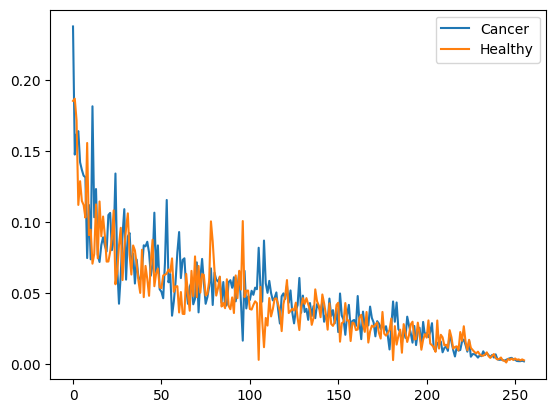

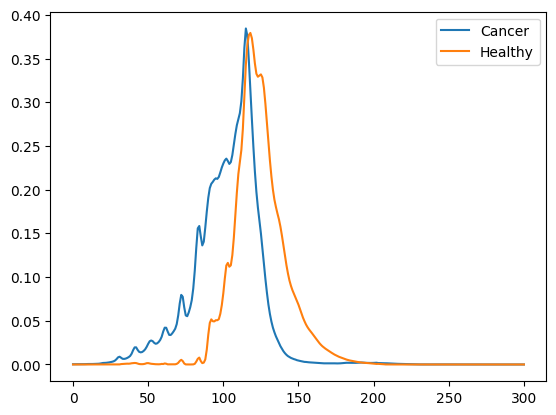

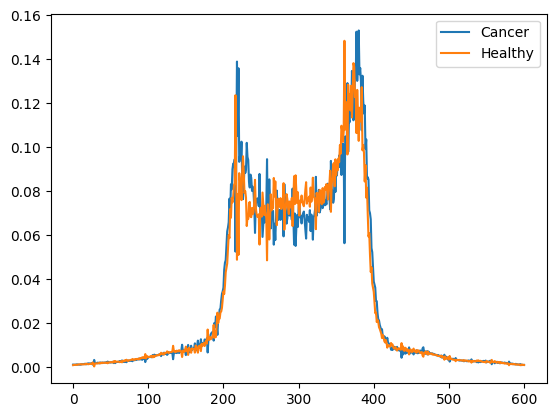

In [19]:
import pandas as pd
import numpy as np
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings("ignore")
from sklearn.mixture import GaussianMixture
import os
import ot
import pickle
import argparse
import Levenshtein
import itertools
from helper_functions import *
##### input args
PROJECT = "gs-mrd"
release_version = "10062024"
merge_version = "20240914"

##### configurations/paths
path_to_main_src = "/media/hieunguyen/HNSD01/src/gs-mrd"
path_to_merge_samples = f"{path_to_main_src}/all_samples/{merge_version}"
path_to_model_files = f"{path_to_main_src}/model_files/{release_version}"
path_to_save_features = f"{path_to_main_src}/model_files/{release_version}/features"

os.system(f"mkdir -p {path_to_save_features}")
os.system(f"mkdir -p {path_to_model_files}")

##### metadata
metadata = pd.read_csv(f"{path_to_model_files}/release_metadata.csv")
general_metadata = pd.read_excel("All Samples GW_MRD_010924.modified.xlsx", index_col = [0])

metadata["Cancer"] = metadata["SampleID"].apply(lambda x: general_metadata[general_metadata["SampleID"] == x.split("-")[1]].Cancer.unique()[0])
metadata["True label"] = metadata["SampleID"].apply(lambda x: general_metadata[general_metadata["SampleID"] == x.split("-")[1]]["True label"].unique()[0])

metadata.to_csv("final_metadata.csv")
# metadata = metadata[metadata["True label"].isin(["+", "-"])]

##### feature matrix
motif_order = pd.read_csv("motif_order.csv").motif_order.to_list()

featuredf = dict()
for input_feature in ["EM", "FLEN", "NUCLEOSOME", "IchorCNA"]:
    tmpdf = pd.read_csv(f"{path_to_merge_samples}/{input_feature}_features.csv")
    tmpdf = tmpdf[tmpdf["SampleID"].isin(metadata.SampleID.unique())]
    if input_feature == "EM":
        featuredf[input_feature] = tmpdf[["SampleID"] + motif_order].copy()
    else:
        featuredf[input_feature] = tmpdf.copy()
        
    assert featuredf[input_feature].shape[0] == metadata.shape[0]
    featuredf[input_feature].to_csv(f"{path_to_save_features}/{input_feature}_features.csv", index = False)

##### generate sample list for each class
samplelist = dict()
for label in metadata.Cancer.unique():
    samplelist[label] = metadata[metadata["Cancer"] == label]["SampleID"].to_list()

##### distance matrix based on edit distance of End motif 4bp
nucleotides = ['A', 'C', 'G', 'T']
motifs = [''.join(p) for p in itertools.product(nucleotides, repeat=4)]

# Initialize an empty distance matrix
distance_matrix = pd.DataFrame(index=motifs, columns=motifs)

# Compute the Levenshtein distance between each pair of 4-mer motifs
for motif1 in motifs:
    for motif2 in motifs:
        distance_matrix.loc[motif1, motif2] = Levenshtein.distance(motif1, motif2)

# Convert the distance matrix to integer type
M_EM = distance_matrix.to_numpy().copy()
M_EM /= M_EM.max() * 0.1

final_features = dict() 

for input_feature in ["EM", "FLEN", "NUCLEOSOME"]:
    ##### generate average FEATURE in all control samples in this batch
    inputdf = featuredf[input_feature].copy().set_index("SampleID").T
    inputdf["Healthy"] = inputdf[samplelist["Healthy"]].mean(axis = 1)
    inputdf[["Healthy"]].to_csv(f"{path_to_model_files}/Healthy_reference_{input_feature}.csv")
    inputdf = inputdf.drop("Healthy", axis = 1)
    
    ##### calculate OT barycenters
    if input_feature == "EM":
        baryl2 = calculate_barycenter(inputdf = featuredf[input_feature].set_index("SampleID").T,
                                      samplelist = samplelist, 
                                      n = inputdf.shape[0], show_plot=False, M = M_EM)
    else: 
        baryl2 = calculate_barycenter(inputdf = featuredf[input_feature].set_index("SampleID").T,
                                      samplelist = samplelist, 
                                      n = inputdf.shape[0], show_plot=False, M = None)
    pd.DataFrame(data = baryl2, columns = ["baryl2"]).to_csv(f"{path_to_model_files}/Healthy_OT_{input_feature}_baryl2.csv", index = False)
    
    ##### NMF models
    X = featuredf[input_feature].set_index("SampleID")
    model = NMF(n_components=2, init='random', random_state=0, solver = "mu")
    W = model.fit_transform(X.to_numpy())
    H = model.components_
    nmfdf = pd.DataFrame(data = W, columns = ["V1", "V2"])
    nmfdf["SampleID"] = list(X.index)
    nmfdf["V1_scale"] = nmfdf[["V1", "V2"]].apply(lambda x: x[0]/sum(x), axis = 1)
    nmfdf["V2_scale"] = nmfdf[["V1", "V2"]].apply(lambda x: x[1]/sum(x), axis = 1)
    nmfdf = nmfdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    sns.lineplot(H[0, ], label = "Cancer")
    sns.lineplot(H[1, ], label = "Healthy")
    plt.legend()
    plt.show()

    signal1 = [i for i,j in enumerate(H[0, ]) if j == np.max(H[0, ])][0]
    signal2 = [i for i,j in enumerate(H[1, ]) if j == np.max(H[1, ])][0]

    if (signal1 < signal2):
        nmf_signal_cancer = 1
    else:
        nmf_signal_cancer = 2
    pd.DataFrame(data = [nmf_signal_cancer], columns = ["nmf_signal_cancer"]).to_csv(f"{path_to_model_files}/NMF_{input_feature}_cancer_signal.csv")
    filename = os.path.join(path_to_model_files, f'NMF_{input_feature}.sav')
    pickle.dump(model, open(filename, 'wb'))
    
    tmpdf = nmfdf[["SampleID", f"V{nmf_signal_cancer}_scale"]].copy()
    tmpdf.columns = ["SampleID", f"NMF_{input_feature}"]
    final_features[f"NMF_{input_feature}"] = tmpdf.copy()

In [20]:
#####--------------------------------------------------------------#####
##### Generate cut-off for this release
#####--------------------------------------------------------------#####

##### absolute difference between a sample and the reference
# prepare references
ref = dict()

em_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_EM.csv")
em_ref.columns = ["motif", "Healthy"]
ref["EM"] = em_ref.copy()

flen_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_FLEN.csv")
flen_ref.columns = ["FLEN", "Healthy"]
ref["FLEN"] = flen_ref.copy()

nuc_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_NUCLEOSOME.csv")
nuc_ref.columns = ["Nucleosome", "Healthy"]
ref["NUCLEOSOME"] = nuc_ref.copy()

all_samples = featuredf["FLEN"].SampleID.unique()

# add score EM, FLEN, NUCLEOSOME to final_features
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    inputdf = featuredf[f].set_index("SampleID").T.copy()
    inputdf["Healthy"] = ref[f]["Healthy"].values
    for sampleid in all_samples:
        inputdf[sampleid] = abs(inputdf[sampleid] - inputdf["Healthy"])
    input_scoredf = inputdf.drop("Healthy", axis = 1).sum().reset_index()
    input_scoredf.columns = ["SampleID", f"{f}_score"]
    input_scoredf = input_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    final_features[f"{f}_score"] = input_scoredf

# add Shannon entropy for EM feature
f = "EM"
inputdf = featuredf[f].set_index("SampleID").T

em_shannondf = pd.DataFrame(data = inputdf.columns, columns = ["SampleID"])
def calculate_em_shannon(x, inputdf):
    tmpdf = inputdf[x].values
    shannon = -np.sum([item * np.log2(item) for item in tmpdf])/256
    return(shannon)
em_shannondf["EM_shannon"] = em_shannondf["SampleID"].apply(lambda x: calculate_em_shannon(x, inputdf))
em_shannondf = em_shannondf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
final_features["EM_shannon"] = em_shannondf

##### OT distance
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    barycenter = pd.read_csv(f"{path_to_model_files}/Healthy_OT_{f}_baryl2.csv")
    bary_l2 = barycenter.baryl2.to_numpy()
    ot_scoredf = pd.DataFrame(data = all_samples, columns = ["SampleID"])
    ot_scoredf[f"OT_{f}"] = ot_scoredf["SampleID"].apply(lambda x: 
        calculate_ot_distance_to_healthy_nuc(x, 
                                             bary_l2, 
                                             featuredf[f].set_index("SampleID").T, 
                                             n = featuredf[f].shape[1] - 1))
    ot_scoredf = ot_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    final_features[f"OT_{f}"] = ot_scoredf
    
final_features["ichorCNA"] = featuredf["IchorCNA"]
outputdf = pd.DataFrame(data = metadata["SampleID"].to_list(), columns = ["SampleID"])
for feat in final_features.keys():
    tmpdf = final_features[feat][["SampleID", feat]]
    tmpdf.columns = ["SampleID", feat]
    outputdf = outputdf.merge(tmpdf, right_on = "SampleID", left_on = "SampleID")

outputdf = outputdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")

cutoffdf = outputdf[outputdf["SampleID"].isin(samplelist["Healthy"])][ ["SampleID"] + list(final_features.keys())].set_index("SampleID").max().reset_index()
cutoffdf.columns = ["feature", "cutoff"]
cutoffdf.to_csv(f"{path_to_model_files}/cutoff.csv", index = False)

In [21]:
outputdf["True_label"] = outputdf[["Cancer", "True label"]].apply(
    lambda x: x[1] if x[0] != "Healthy" else "Healthy", axis = 1
)

<Axes: xlabel='True_label', ylabel='FLEN_score'>

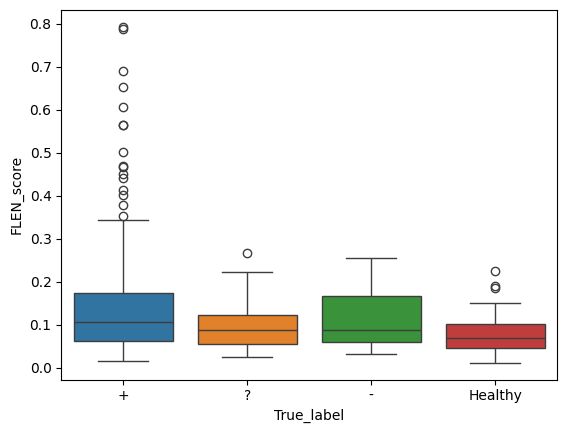

In [22]:
sns.boxplot(outputdf, x = "True_label", y = "FLEN_score", hue = "True_label")

<Axes: xlabel='True_label', ylabel='NMF_FLEN'>

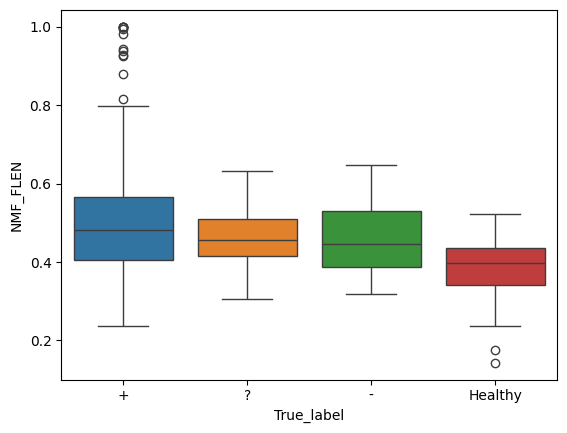

In [23]:
sns.boxplot(outputdf, x = "True_label", y = "NMF_FLEN", hue = "True_label")

<Axes: xlabel='True_label', ylabel='ichorCNA'>

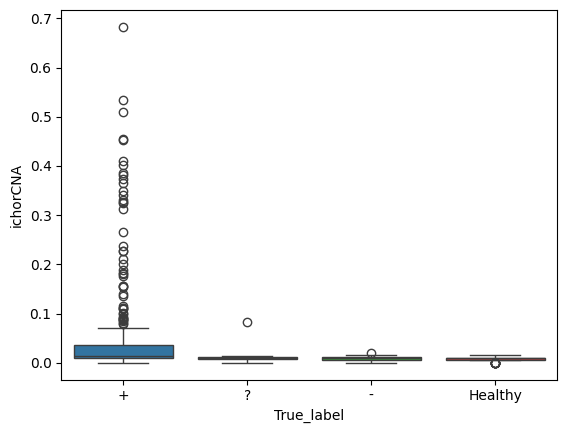

In [24]:
sns.boxplot(outputdf, x = "True_label", y = "ichorCNA", hue = "True_label")

In [25]:
outputdf.groupby("True_label")["SampleID"].count()

True_label
+          262
-           32
?           41
Healthy     53
Name: SampleID, dtype: int64

In [26]:
outputdf.to_csv(f"{path_to_model_files}/traindf.csv", index = False)


In [28]:
metadata.to_csv(os.path.join(path_to_model_files, "metadata.csv"))